## Traininig of the High Level Feature classifier with Pytorch Lightning

**PyTorch Lightning, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses Pytorch Lightning on a single node. Pandas is used to read the data and pass it to Lightning.

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"

## Load train and test datasets via Pandas

In [1]:
# Download the datasets from 
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"

import pandas as pd

testPDF = pd.read_parquet(path= PATH + 'testUndersampled_HLF_features.parquet', 
                          columns=['HLF_input', 'encoded_label'])

trainPDF = pd.read_parquet(path= PATH + 'trainUndersampled_HLF_features.parquet', 
                           columns=['HLF_input', 'encoded_label'])

In [2]:
# Check the number of events in the train and test datasets

num_test = testPDF.count()
num_train = trainPDF.count()

print('There are {} events in the test dataset'.format(num_test))
print('There are {} events in the train dataset'.format(num_train))

There are HLF_input        856090
encoded_label    856090
dtype: int64 events in the test dataset
There are HLF_input        3426083
encoded_label    3426083
dtype: int64 events in the train dataset


In [3]:
# Show the schema and a data sample of the test dataset
testPDF


,HLF_input,encoded_label
0,"[0.015150733133517018, 0.003511028294205839, 0...","[1.0, 0.0, 0.0]"
1,"[0.0, 0.003881822832783805, 0.7166341448458555...","[1.0, 0.0, 0.0]"
2,"[0.009639073600865505, 0.0010022659022912096, ...","[1.0, 0.0, 0.0]"
3,"[0.016354407625436572, 0.002108937905084598, 0...","[1.0, 0.0, 0.0]"
4,"[0.01925979125354152, 0.004603697276827594, 0....","[1.0, 0.0, 0.0]"
...,...,...
856085,"[0.020383967386165446, 0.0022348975484913444, ...","[0.0, 1.0, 0.0]"
856086,"[0.02475209699743233, 0.00867502196073073, 0.3...","[0.0, 1.0, 0.0]"
856087,"[0.03498179428310887, 0.02506331737284528, 0.9...","[0.0, 1.0, 0.0]"
856088,"[0.03735147362869153, 0.003645269183639405, 0....","[0.0, 1.0, 0.0]"


## Convert training and test datasets from Pandas DataFrames to Numpy arrays

Now we will collect and convert the Pandas DataFrame into numpy arrays in order to be able to feed them to TensorFlow/Keras.


In [4]:
import numpy as np

X = np.stack(trainPDF["HLF_input"]).astype(np.float32)
y = np.stack(trainPDF["encoded_label"]).astype(np.float32)

X_test = np.stack(testPDF["HLF_input"]).astype(np.float32)
y_test = np.stack(testPDF["encoded_label"]).astype(np.float32)

## Create PyTorch Lightning model

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import pytorch_lightning as pl

torch.__version__
pl.__version__

'2.2.4'

In [6]:
torch.cuda.is_available()

True

In [7]:
class LightningNet(pl.LightningModule):
    def __init__(self, nh_1, nh_2, nh_3):
        super(LightningNet, self).__init__()
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.fc1 = nn.Linear(14, nh_1)
        self.fc2 = nn.Linear(nh_1, nh_2)
        self.fc3 = nn.Linear(nh_2, nh_3)
        self.fc4 = nn.Linear(nh_3, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = F.softmax(self.fc4(x), dim=1)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        
        # Compute accuracy
        y_pred = torch.sigmoid(y_hat) > 0.5
        accuracy = (y_pred == y).sum().item() / (y.numel())
        
        self.log('train_loss', loss)
        self.log('train_acc', accuracy, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        
        # Compute accuracy
        y_pred = torch.sigmoid(y_hat) > 0.5
        accuracy = (y_pred == y).sum().item() / (y.numel())
        
        self.log('val_loss', loss)
        self.log('val_acc', accuracy, prog_bar=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': StepLR(optimizer, step_size=1, gamma=0.7),
                'interval': 'epoch'
            }
        }

In [8]:
class TensorDataModule(pl.LightningDataModule):
    def __init__(self, train_X, train_y, val_X=None, val_y=None, batch_size=32, num_workers=0):
        super().__init__()
        self.train_X = train_X
        self.train_y = train_y
        self.val_X = val_X
        self.val_y = val_y
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_dataset = TensorDataset(torch.tensor(self.train_X, dtype=torch.float32), torch.tensor(self.train_y, dtype=torch.float32))

        if self.val_X is not None and self.val_y is not None:
            self.val_dataset = TensorDataset(torch.tensor(self.val_X, dtype=torch.float32), torch.tensor(self.val_y, dtype=torch.float32))
                                                          
    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        return train_loader

    def val_dataloader(self):
        if hasattr(self, 'val_dataset'):
            val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
            return val_loader


In [9]:
class HistoryCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        # Extract training/validation loss and accuracy from the trainer object
        train_loss = trainer.callback_metrics['train_loss']
        val_loss = trainer.callback_metrics['val_loss']
        train_acc = trainer.callback_metrics['train_acc']
        val_acc = trainer.callback_metrics['val_acc']
        
        # Store the history
        pl_module.train_loss_history.append(train_loss.item())
        pl_module.val_loss_history.append(val_loss.item())
        pl_module.train_acc_history.append(train_acc.item())
        pl_module.val_acc_history.append(val_acc.item())
        
    def on_epoch_start(self, trainer, pl_module):
        super().on_epoch_start(trainer, pl_module)
        
        # Update the progress bar with metrics from previous epochs
        self.main_progress_bar.set_postfix(trainer.logger_connector.epoch_log_metrics)
        self.main_progress_bar.refresh()

## Train the model

In [10]:
# Setup and run the training

device = torch.device("cuda")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 5
train_batch_size = 128
num_workers = 4
torch.manual_seed(1)

data_module = TensorDataModule(X, y, X_test, y_test, train_batch_size, num_workers)

model = LightningNet(50, 20, 10)

history_callback = HistoryCallback()

trainer = pl.Trainer(max_epochs=num_epochs, callbacks=[history_callback])

%time trainer.fit(model, data_module) 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /eos/home-i04/c/canali/SWAN_projects/SparkDLTrigger/Training_HLF_Classifier/lightning_logs
2024-06-11 16:40:15.434217: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 16:40:15.510025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 16:40:19.342558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could no

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 17min 54s, sys: 2min 45s, total: 20min 40s
Wall time: 21min 5s


In [11]:
trainer.validate(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8454755544662476     │
│         val_loss          │    0.5965720415115356     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5965720415115356, 'val_acc': 0.8454755544662476}]

## Performance metrics

<IPython.core.display.Javascript object>


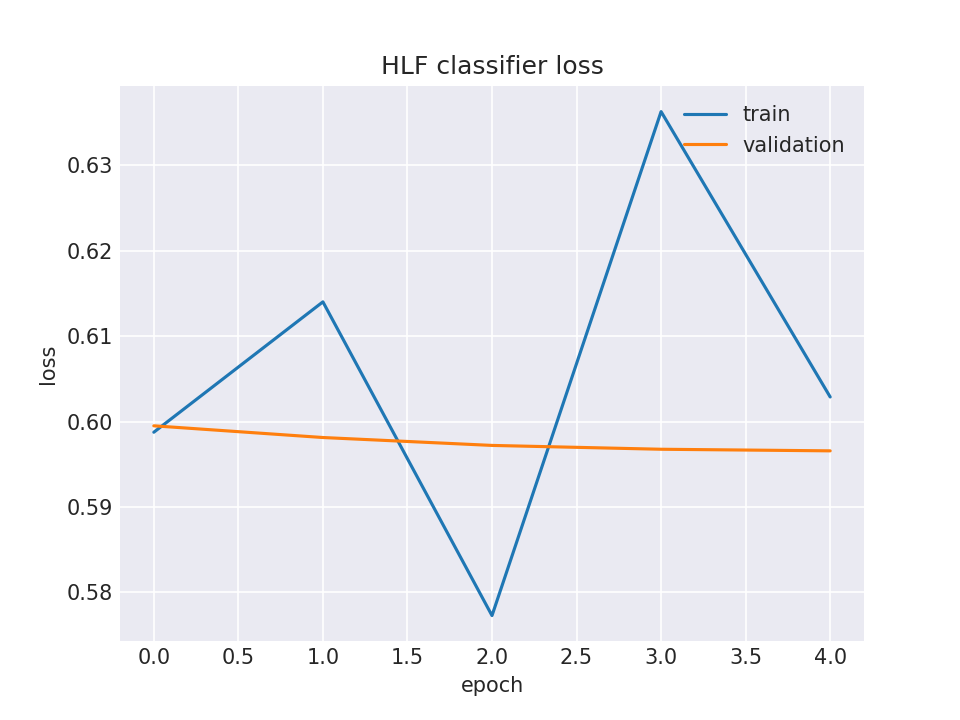

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(model.train_loss_history, label='train')
plt.plot(model.val_loss_history, label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


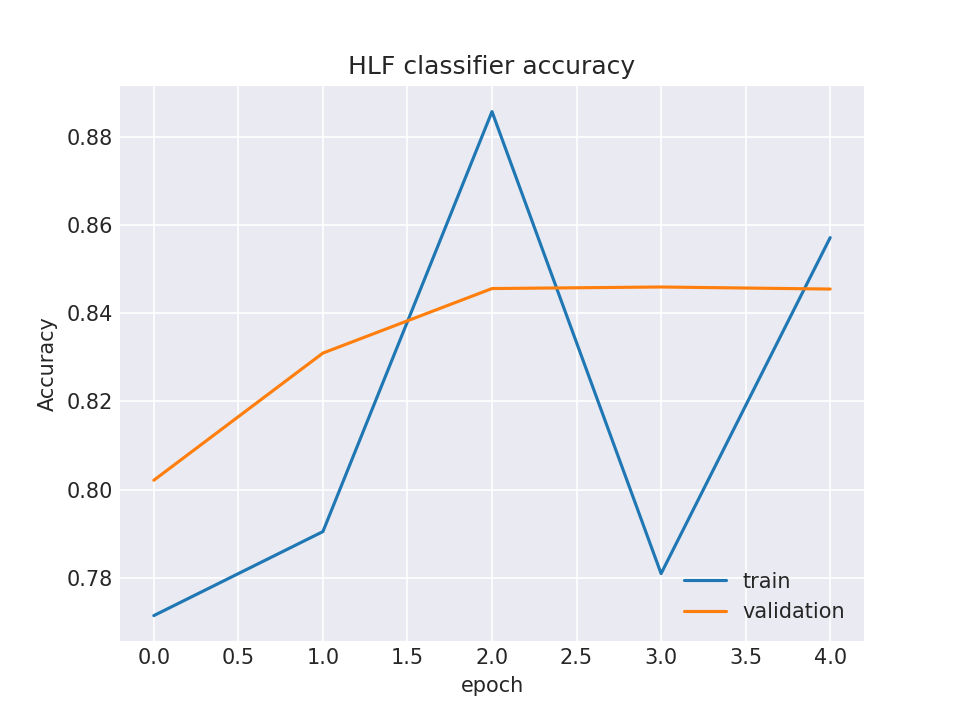

In [13]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(model.train_acc_history, label='train')
plt.plot(model.val_acc_history, label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [14]:
y_pred = model(torch.tensor(X_test)).detach().numpy() 
y_true=y_test

In [15]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9092


<IPython.core.display.Javascript object>


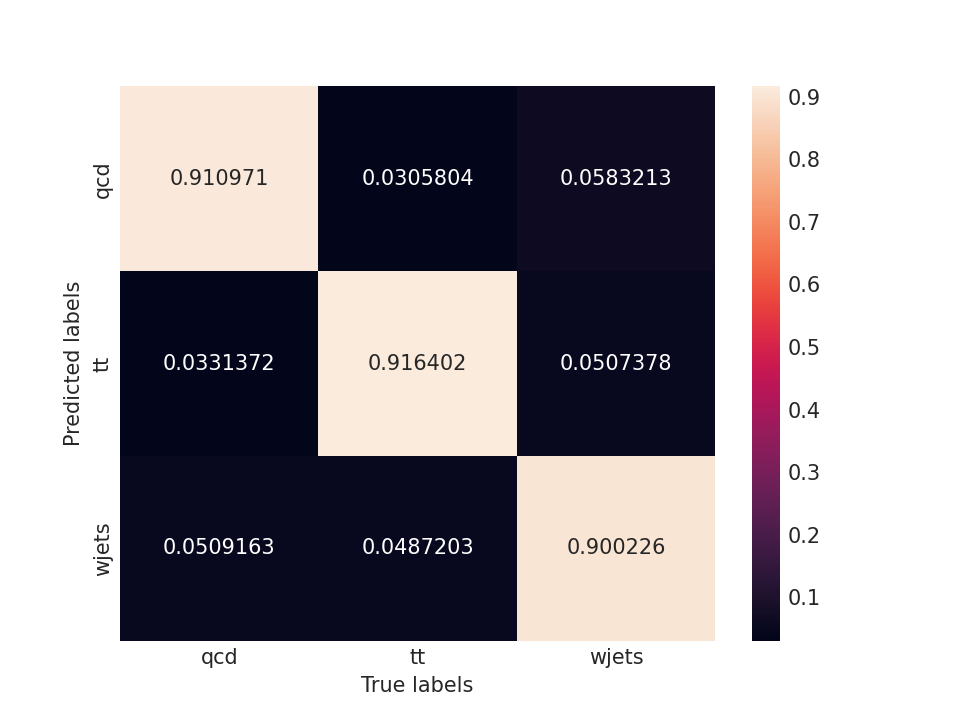

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [17]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [18]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.982741351221958, 1: 0.9765844500813086, 2: 0.9721584488929513}

<IPython.core.display.Javascript object>


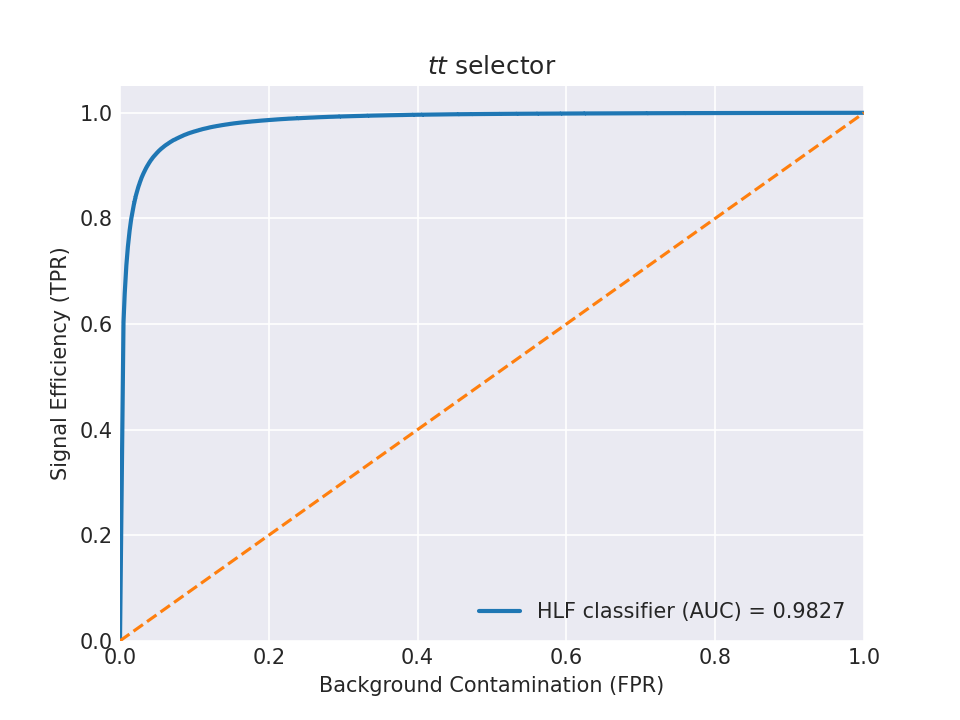

In [19]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()